In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from sys import path
path.insert(0, "lib")
from minima import *
from colorline import colorline

%load_ext autoreload
%autoreload 2

In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ExponentialConvectionTerm

from fipy.tools import numerix

# Simple diffusion example
* Based on [this example](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.mesh1D.html)
* Generic info about numerical schemes [here](https://www.ctcms.nist.gov/fipy/documentation/numerical/scheme.html#sec-numericalschemes)

In [3]:
nx = 50

dx = 1.

mesh = Grid1D(nx=nx, dx=dx)

In [4]:
phi = CellVariable(mesh=mesh, name=r"$\phi$")

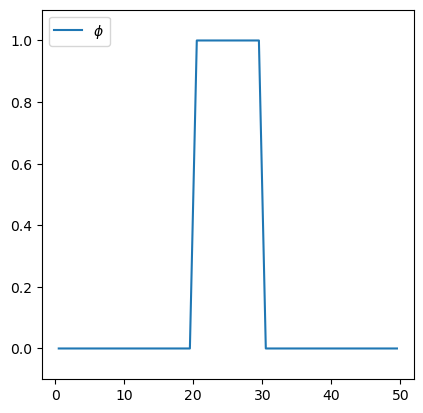

In [5]:
phi.value = 0.

L = 50 
x = mesh.cellCenters[0]

phi.setValue(1., where=(x > L/2. - L/10.) & (x < L/2. + L/10.))

viewer = Viewer(vars=phi, datamin=-0.1, datamax=1.1)

In [6]:
# non-uniform diffusion coefficient
D = FaceVariable(mesh=mesh, value=1.0)
X = mesh.faceCenters[0]
D.setValue(0.1, where=(L / 4. <= X) & (X < 3. * L / 4.))

# no boundary conditions: default no flux bc

# valueLeft = 1
# valueRight = 0
# phi.constrain(valueRight, mesh.facesRight)
# phi.constrain(valueLeft, mesh.facesLeft)

# explicit
eq = TransientTerm() == DiffusionTerm(D)

In [7]:
dt = 10. * dx**2 / (2 * D[0])
steps = 200

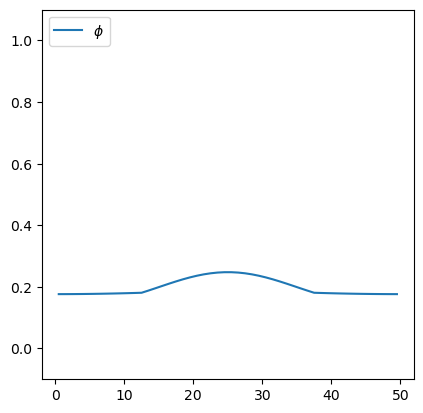

In [8]:
for step in range(steps):
    eq.solve(var=phi, dt=dt)
    viewer.plot()

# 1D linear model

In [152]:
nw = 300
dw = 1
L = 1.
mesh = Grid1D(nx=nw, dx=dw, Lx=L)

In [153]:
P = CellVariable(mesh=mesh, name=r"$P$")

In [174]:
P.value = 0.

w = mesh.cellCenters[0]

# (unconventional normalization)
P.setValue(1.)

# viewer = Viewer(vars=P, datamin=-0.1, datamax=1.1)

In [175]:
# non-uniform diffusion coefficient
# D = FaceVariable(mesh=mesh, value=1.0)
w = mesh.cellCenters[0]
w0 = .5
l = .02
b = 1
v = 1.
ve = 1.
D2 = (l**2*v*(2+v*(1-2*w)**2))/(4*b)

w = mesh.faceCenters[0]
minusD1plusgradD2 = (l*v*(b+l*v)*(-1+2*w))/(2*b)
# unit vector
u = FaceVariable(mesh=mesh, value = 1., rank=1)

# explicit
eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = minusD1plusgradD2))

In [176]:
dt = 2. * dw**2 / (2)
steps = 1000

In [177]:
Ps = [P.copy()]
for step in range(steps):
    eq.solve(var=P, dt=dt)
    Ps.append(P.copy())

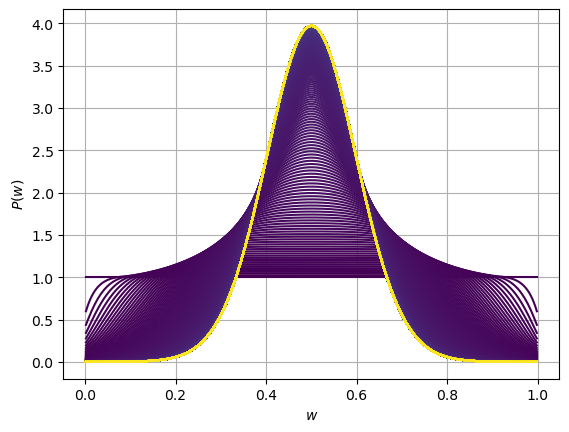

In [178]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(mesh.x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.savefig("dynamics_linear_model.png", bbox_inches="tight", dpi=150)

In [184]:
def get_FP_data(l, b):
    nw = 300
    dw = 1
    L = 1.
    mesh = Grid1D(nx=nw, dx=dw, Lx=L)
    
    P = CellVariable(mesh=mesh, name=r"$P$")
    P.value = 0.
    w = mesh.cellCenters[0]
    # (unconventional normalization)
    P.setValue(1.)


    w = mesh.cellCenters[0]
    w0 = .5
    v = 1.
    ve = 1.
    D2 = (l**2*v*(2+v*(1-2*w)**2))/(4*b)
    
    w = mesh.faceCenters[0]
    minusD1plusgradD2 = (l*v*(b+l*v)*(-1+2*w))/(2*b)
    # unit vector
    u = FaceVariable(mesh=mesh, value = 1., rank=1)
    
    # explicit
    eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = minusD1plusgradD2))

    dt = 2. * dw**2 / (2)
    steps = 1000

    Ps = [P.copy()]
    for step in range(steps):
        eq.solve(var=P, dt=dt)
        Ps.append(P.copy())

    return Ps

In [186]:
Pdata = []
for b in [1, 10]:
    Ps = get_FP_data(l=0.02, b=b)
    Pdata.append(Ps[-1])

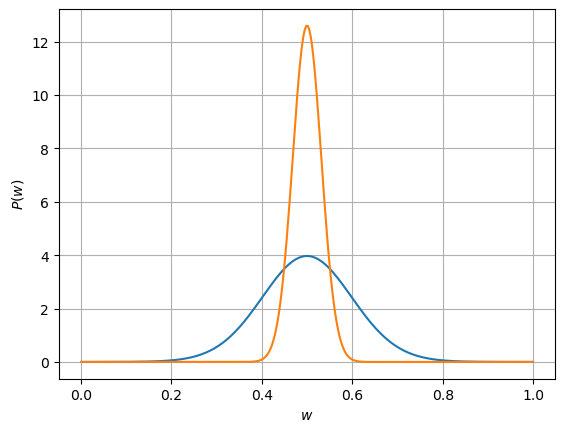

In [188]:
for P in Pdata:
    plt.plot(mesh.x, P)
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()

## Comparison with SGD

In [160]:
class SGD:
    """
    Exact SGD dynamics
    """
    def __init__(self, lr, q, grad_q, w_init, nsamp, batchsize, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.nb = batchsize
        self.w = [w_init]
        self.state = np.random.RandomState(seed=seed)
        # uncorrelated X and Y data
        self.x, self.y = self.state.normal(size=(2, nsamp))
        
    def update(self, w_old):
        xb = self.state.choice(self.x, self.nb)
        yb = self.state.choice(self.y, self.nb)
        
        xi_xx = np.mean(xb*xb)
        xi_xy = np.mean(xb*yb)
        return w_old - self.lr*(xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
    
    def evolve(self, nstep):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc)
            self.w.append(wc)


In [191]:
def q(w):
    return w-.5
    
def grad_q(w):
    return 1.

def get_data(lr, nsamp, batchsize):
    w_init = .1
    seed = 42
    S = SGD(lr, q, grad_q, w_init, nsamp, batchsize, seed)
    S.evolve(10**6)
    return S.w

In [192]:
ws = [get_data(lr = 0.02, nsamp=10**6, batchsize = b) for b in [1, 10, 100]]

In [193]:
ws = np.array(ws)

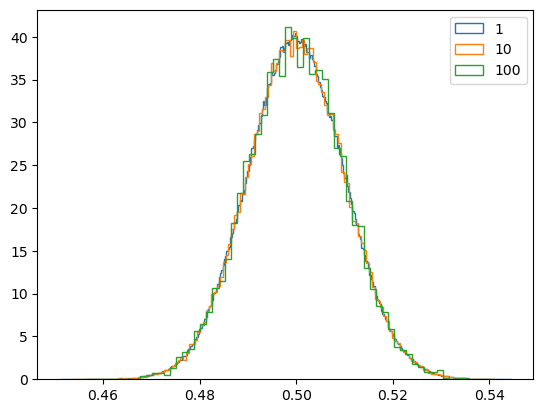

In [198]:
# histograms for different autocorrelation times
ti = 10**3
for tc in [1, 10, 100]:
    data = ws[2][ti::tc]
    plt.hist(data, bins='auto', histtype='step', label=f'{tc}', density=True)
plt.legend()
plt.show()

In [199]:
Pdata = []
for b in [1, 10, 100]:
    Ps = get_FP_data(l=0.02, b=b)
    Pdata.append(Ps[-1])

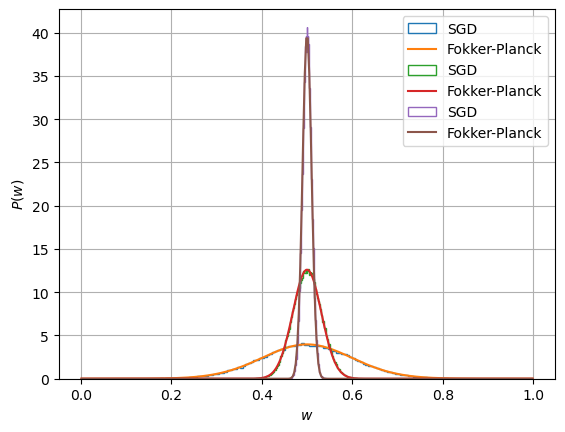

In [200]:
ti = 10**3
tc = 10
for w, P in zip(ws, Pdata):
    data = w[ti::tc]
    plt.hist(data, bins='auto', histtype='step', label='SGD', density=True)

    plt.plot(mesh.x, P, label='Fokker-Planck')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.legend()
plt.grid()
plt.savefig("dynamics_linear_model.png", bbox_inches="tight", dpi=150)

# 1D non-linear, singular model

In [118]:
nw = 300
dw = 1
L = 3.
mesh = Grid1D(nx=nw, dx=dw, Lx=L)

In [119]:
P = CellVariable(mesh=mesh, name=r"$P$")

In [34]:
P.value = 0.

w = mesh.cellCenters[0]

# (unconventional normalization)
P.setValue(1.)

In [35]:
# non-uniform diffusion coefficient
# D = FaceVariable(mesh=mesh, value=1.0)
w = mesh.cellCenters[0]
w0 = .5
l = .002
v = 1.
ve = 1.
D2 = .5*l**2*(1+2*(-2+w)**2*(-1+w)**4)*(5-8*w+3*w**2)**2

w = mesh.faceCenters[0]
D1 = l*(-1+w)*(-5+3*w)*(-((-2+w)*(-1+w)**2)+l*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w))))))))
gradD2 = 2*l**2*(-1+w)*(-5+3*w)*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w)))))))
# unit vector
u = FaceVariable(mesh=mesh, value = 1., rank=1)

# explicit
eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = -D1 + gradD2))

In [36]:
dt = 2. * dx**2 / (2)
steps = 5000

In [37]:
Ps = [P.copy()]
for step in range(steps):
    eq.solve(var=P, dt=dt)
    Ps.append(P.copy())

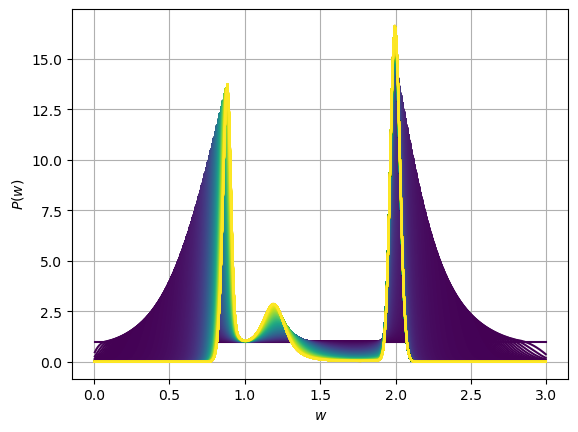

In [38]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(mesh.x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

## 1D singular model (quadratic model)

In [66]:
nw = 300
dw = 1
L = 2.
mesh = Grid1D(nx=nw, dx=dw, Lx=L)

In [67]:
P = CellVariable(mesh=mesh, name=r"$P$")

In [113]:
P.value = 0.

w = mesh.cellCenters[0]

# (unconventional normalization)
P.setValue(1.)

In [114]:
# non-uniform diffusion coefficient
# D = FaceVariable(mesh=mesh, value=1.0)
w = mesh.cellCenters[0]
w0 = .5
l = .002
b = 10**3
v = 1.
ve = 1.
D2 = 2*l**2*v*(w-1)**2*(1+2*v*(w-1)**4)/b

w = mesh.faceCenters[0]
# D1 = l*(-1+w)*(-5+3*w)*(-((-2+w)*(-1+w)**2)+l*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w))))))))
# gradD2 = 2*l**2*(-1+w)*(-5+3*w)*(-86+w*(472+w*(-1136+w*(1509+w*(-1186+w*(551+5*w*(-28+3*w)))))))
minusD1plusgradD2 = (2*l*v*(l*(1+6*v*(-1+w)**4)+b*(-1+w)**2)*(-1+w))/b
# unit vector
u = FaceVariable(mesh=mesh, value = 1., rank=1)

# explicit
eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = minusD1plusgradD2))

In [115]:
dt = 10. * dw**2 / (2)
steps = 500

In [116]:
Ps = [P.copy()]
for step in range(steps):
    eq.solve(var=P, dt=dt)
    Ps.append(P.copy())

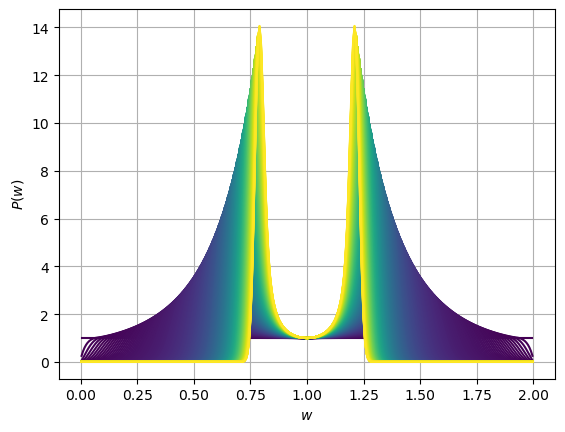

In [117]:
cmap = plt.get_cmap('viridis')
for i, P in enumerate(Ps):
    plt.plot(mesh.x, P, color = cmap(i / len(Ps)))
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()